# 1D VP-System with FVM

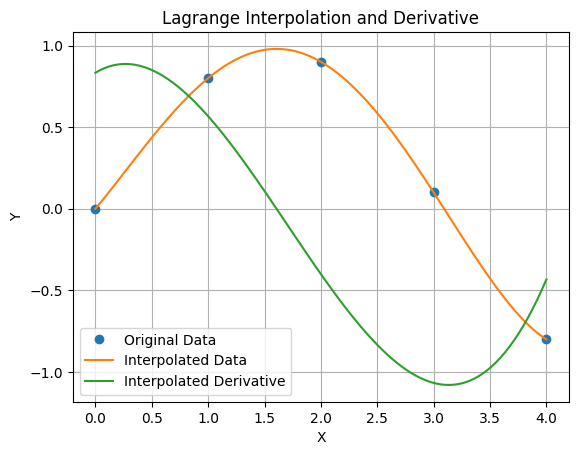

In [125]:
import numpy as np
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt

# 定义原始数据点
x = np.array([0, 1, 2, 3, 4])
y = np.array([0, 0.8, 0.9, 0.1, -0.8])

# 使用 lagrange 函数进行拉格朗日插值
poly = lagrange(x, y)

# 计算多项式的导数
poly_derivative = poly.deriv()

# 生成一些测试点
x_test = np.linspace(0, 4, 100)
y_interp = poly(x_test)
y_derivative = poly_derivative(x_test)

# 绘制原始数据、插值结果和导数结果
plt.plot(x, y, 'o', label='Original Data')
plt.plot(x_test, y_interp, label='Interpolated Data')
plt.plot(x_test, y_derivative, label='Interpolated Derivative')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Lagrange Interpolation and Derivative')
plt.grid(True)
plt.show()


## 输入库

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.interpolate import lagrange
from scipy.special import roots_sh_legendre

n = 5
theta = 0.7*2*np.pi

## 功能函数

2D 拉格朗日插值

In [127]:
def TestF(x,y,xDiv,yDiv):

  x1 = np.cos(theta)*x + np.sin(theta)*y
  y1 = -np.sin(theta)*x + np.cos(theta)*y
  x1x = np.cos(theta)
  x1y = np.sin(theta)
  y1x = -np.sin(theta)
  y1y = np.cos(theta)

  k1 = 0.05*np.pi
  k2 = 0.1*np.pi
  phi1 = k1*(x1+7)
  phi2 = k2*(y1+4)

  f1 = np.cos(phi1)
  f2 = np.sin(phi2)

  f1x1 = -k1*np.sin(phi1)
  f2x1 = 0.0
  f1y1 = 0.0
  f2y1 =  k2*np.cos(phi2)

  if xDiv==1:
    f1x = f1x1*x1x+f1y1*y1x
    f2x = f2x1*x1x+f2y1*y1x
    re = f1*f2x + f1x*f2
  elif yDiv==1:
    f1y = f1x1*x1y+f1y1*y1y
    f2y = f2x1*x1y+f2y1*y1y
    re = f1*f2y + f1y*f2
  else:
    re = f1*f2
  
  return re

In [128]:
def LagF(xNode,yNode,zNode,x,y,xDiv,yDiv):
  Nx,Ny = zNode.shape
  re = 0.0

  Lix = Li if xDiv==0 else divLi
  Liy = Li if yDiv==0 else divLi

  for i in range(0,Nx):
    for j in range(0,Ny):
      re += zNode[i,j]*Lix(xNode[:,0],i,x)*Liy(yNode[0,:],j,y)
  return re


def Li_unit(x0,x1,x):
  return (x-x1)/(x0-x1)

def Li(xNode,i,x):
  N = xNode.shape[0]
  re = 1.0
  for j in range(0,N):
    if j != i:
      re *= Li_unit(xNode[i],xNode[j],x)
  return re

def divLi(xNode,i,x):
  err = 1e-10
  N = xNode.shape[0]
  re = 0.0
  for j in range(0,N):
    if j != i:
      re += 1.0/((x-xNode[j]) + err)
  re *= Li(xNode,i,x)
  return re

In [129]:
def LagF1(xNode,zxNode,yNode,zyNode,x,y,xDiv,yDiv):
  N = xNode.shape[0]
  
  Lix = Li if xDiv==0 else divLi
  Liy = Li if yDiv==0 else divLi
  zyNode1 = zyNode/zxNode[round((N-1)/2)]

  Lx,Ly = 0.0,0.0
  for i in range(0,N):
    Lx += zxNode[i]*Lix(xNode,i,x)
    Ly += zyNode1[i]*Liy(yNode,i,y)

  return Lx*Ly

In [143]:
def CoeLagF2(xNode, yNode, zNode):
  Ypolys = [lagrange(yNode,zNode[i,:]) for i in range(zNode.shape[0])]
  Xpolys = [lagrange(xNode,zNode[:,i]) for i in range(zNode.shape[1])]
  return Xpolys, Ypolys


def LagF2(Xpolys,Ypolys,x,y):
  xVals = np.polyval(Xpolys,x)
  yVals = np.polyval(Ypolys,y)
  re = 0.0
  for i in range(0,xVals.shape[0]):
    for j in range(0,yVals.shape[0]):
      re += xVals[i]*yVals[j]
  return re    

#def lagrange(xNode, yNode):
#    """Return the Lagrange polynomial for the given nodes."""
#    n = len(yNode)
#    if n == 1:
#        return lambda x: yNode[0]
#    else:
#        def lagrange(x):
#            result = 0
#            for j in range(n):
#                v = yNode[j]
#                for k in range(n):

In [131]:
nodes, weights = roots_sh_legendre(n)

In [132]:
x = np.linspace(0,1,100).reshape(-1, 1)
y = np.linspace(0,1,100).reshape( 1,-1)

In [133]:
xL0 = nodes.reshape(-1, 1)
yL0 = nodes.reshape( 1,-1)
zL0 = TestF(xL0,yL0,0,0)

In [134]:
xL1 = nodes
yL1 = nodes
nmid = round((n-1)/2)
zLx = TestF(xL1,yL1[nmid],0,0)
zLy = TestF(xL1[nmid],yL1,0,0)

In [135]:
z0 = TestF(x,y,0,0)
zx0 = TestF(x,y,1,0)
zy0 = TestF(x,y,0,1)

In [136]:
z1 = LagF(xL0,yL0,zL0,x,y,0,0)
zy1 = LagF(xL0,yL0,zL0,x,y,1,0)
zx1 = LagF(xL0,yL0,zL0,x,y,0,1)


In [137]:
#z2 = LagF1(xL1,zLx,yL1,zLy,x,y,0,0)
#zx2 = LagF1(xL1,zLx,yL1,zLy,x,y,1,0)
#zy2 = LagF1(xL1,zLx,yL1,zLy,x,y,0,1)

In [148]:
Xpoly,Ypoly = CoeLagF2(xL1, yL1, zL0)

dXpoly = [poly.deriv() for poly in Xpoly]
dYpoly = [poly.deriv() for poly in Ypoly]

z2 = np.zeros_like(z0)
zx2 = np.zeros_like(z0)
zy2 = np.zeros_like(z0)
for i in range(x.shape[0]):
  for j in range(y.shape[1]):
    z2[i,j] = LagF2(Xpoly,Ypoly,x[i,0], y[0,j])
    zx2[i,j] = LagF2(dXpoly,Ypoly,x[i,0], y[0,j])
    zy2[i,j] = LagF2(Xpoly,dYpoly,x[i,0], y[0,j])

In [149]:
h = 1.0/(np.max(z0)-np.min(z0))
hx = 1.0/(np.max(zx0)-np.min(zx0))
hy = 1.0/(np.max(zy0)-np.min(zy0))

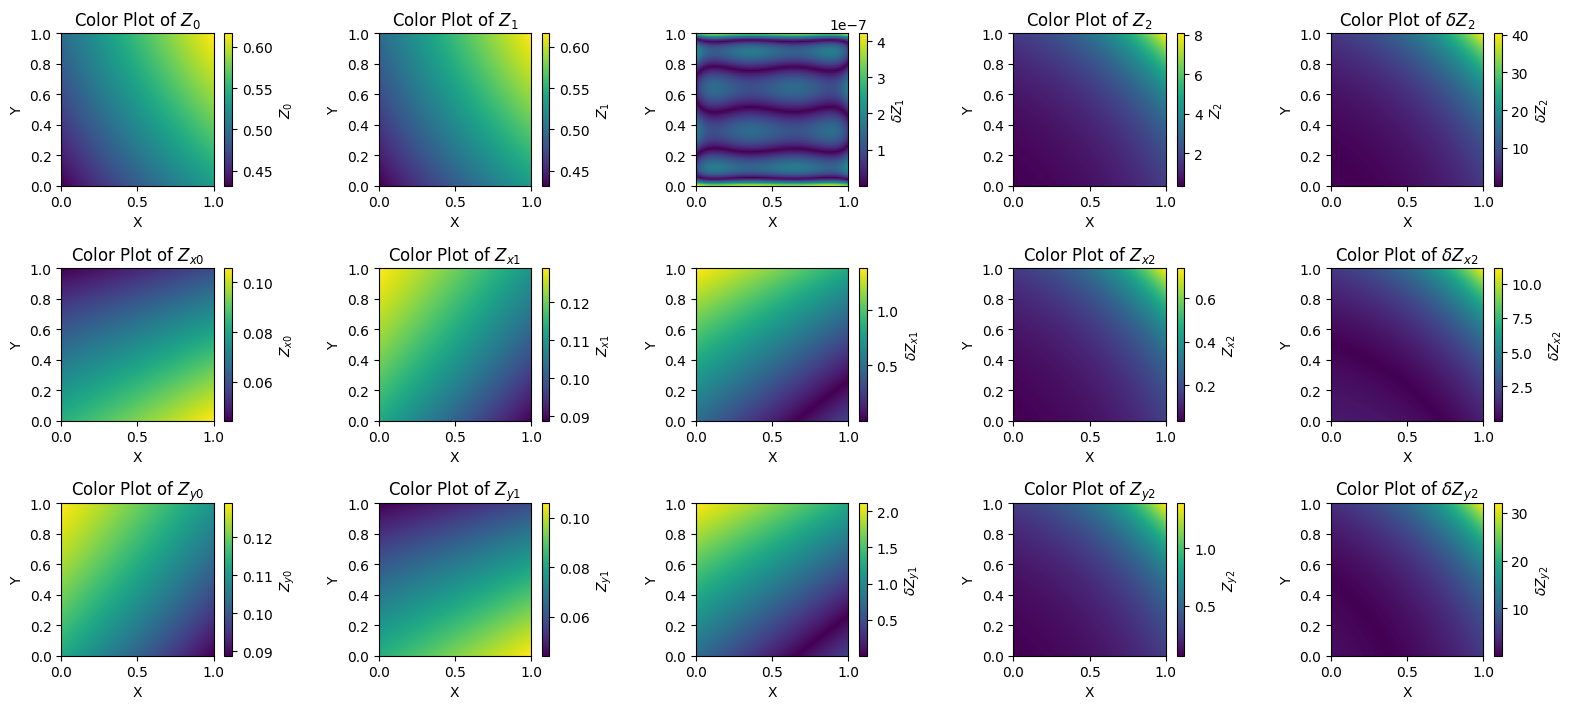

In [150]:
factor = 0.8


# 创建图形和子图
fig, axes = plt.subplots(3, 5, figsize=(20*factor, 9*factor))
#fig, axes = plt.subplots(3, 5)
extent0=[x.min(), x.max(), y.min(), y.max()]

# 解析数据
ax00 = axes[0,0]
im00 = ax00.imshow(z0, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im00, ax=ax00, label='$Z_0$')
ax00.set_xlabel('X')
ax00.set_ylabel('Y')
ax00.set_title('Color Plot of $Z_0$')

ax10 = axes[1,0]
im10 = ax10.imshow(zx0, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im10, ax=ax10, label='$Z_{x0}$')
ax10.set_xlabel('X')
ax10.set_ylabel('Y')
ax10.set_title('Color Plot of $Z_{x0}$')

ax20 = axes[2,0]
im20 = ax20.imshow(zy0, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im20, ax=ax20, label='$Z_{y0}$')
ax20.set_xlabel('X')
ax20.set_ylabel('Y')
ax20.set_title('Color Plot of $Z_{y0}$')



# 第一种插值方法数据
ax01 = axes[0,1]
im01 = ax01.imshow(z1, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im01, ax=ax01, label='$Z_1$')
ax01.set_xlabel('X')
ax01.set_ylabel('Y')
ax01.set_title('Color Plot of $Z_1$')

ax11 = axes[1,1]
im11 = ax11.imshow(zx1, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im11, ax=ax11, label='$Z_{x1}$')
ax11.set_xlabel('X')
ax11.set_ylabel('Y')
ax11.set_title('Color Plot of $Z_{x1}$')

ax21 = axes[2,1]
im21 = ax21.imshow(zy1, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im21, ax=ax21, label='$Z_{y1}$')
ax21.set_xlabel('X')
ax21.set_ylabel('Y')
ax21.set_title('Color Plot of $Z_{y1}$')


# 误差
ax02 = axes[0,2]
im02 = ax02.imshow(np.abs(z1-z0)*h, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im02, ax=ax02, label='$\delta Z_{1}$')
ax02.set_xlabel('X')
ax02.set_ylabel('Y')
#ax02.set_title('Color Plot of $\delta Z_{1}$')

ax12 = axes[1,2]
im12 = ax12.imshow(np.abs(zx1-zx0)*hx, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im12, ax=ax12, label='$\delta Z_{x1}$')
ax12.set_xlabel('X')
ax12.set_ylabel('Y')
#ax12.set_title('Color Plot of $\delta Z_{x1}$')

ax22 = axes[2,2]
im22 = ax22.imshow(np.abs(zy1-zy0)*hy, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im22, ax=ax22, label='$\delta Z_{y1}$')
ax22.set_xlabel('X')
ax22.set_ylabel('Y')
#ax22.set_title('Color Plot of $\delta Z_{y1}$')


# 第二种插值方法数据
ax03 = axes[0,3]
im03 = ax03.imshow(z2, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im03, ax=ax03, label='$Z_2$')
ax03.set_xlabel('X')
ax03.set_ylabel('Y')
ax03.set_title('Color Plot of $Z_2$')

ax13 = axes[1,3]
im13 = ax13.imshow(zx2, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im13, ax=ax13, label='$Z_{x2}$')
ax13.set_xlabel('X')
ax13.set_ylabel('Y')
ax13.set_title('Color Plot of $Z_{x2}$')

ax23 = axes[2,3]
im23 = ax23.imshow(zy2, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im23, ax=ax23, label='$Z_{y2}$')
ax23.set_xlabel('X')
ax23.set_ylabel('Y')
ax23.set_title('Color Plot of $Z_{y2}$')


# 误差
ax04 = axes[0,4]
im04 = ax04.imshow(np.abs(z2-z0)*h, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im04, ax=ax04, label='$\delta Z_{2}$')
ax04.set_xlabel('X')
ax04.set_ylabel('Y')
ax04.set_title('Color Plot of $\delta Z_{2}$')

ax14 = axes[1,4]
im14 = ax14.imshow(np.abs(zx2-zx0)*hx, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im14, ax=ax14, label='$\delta Z_{x2}$')
ax14.set_xlabel('X')
ax14.set_ylabel('Y')
ax14.set_title('Color Plot of $\delta Z_{x2}$')

ax24 = axes[2,4]
im24 = ax24.imshow(np.abs(zy2-zy0)*hy, extent=extent0, origin='lower', cmap='viridis')
plt.colorbar(im24, ax=ax24, label='$\delta Z_{y2}$')
ax24.set_xlabel('X')
ax24.set_ylabel('Y')
ax24.set_title('Color Plot of $\delta Z_{y2}$')


# 显示图形
plt.tight_layout()
plt.show()

### 格式

In [ ]:
def Scheming(Schemer,*args):
  def warpper(*args):
    return Schemer(*args)
  return warpper


@Scheming
def REC_WENO(U,bc,Limiter):
  Nb = U.shape[0] + 1
  UL = np.zeros((Nb))
  UR = np.zeros((Nb))

  if bc == 'Periodic':
    UE = np.concatenate((U[-3:],U,U[:3]))
  else:
    ones = np.ones((3))
    UE = np.concatenate((U[0]*ones,U,U[-1:]*ones))

  for j in range(0, Nb):
    UL[j] = Limiting(Limiter)(UE[j:j+5])
    UR[j] = Limiting(Limiter)(UE[j+5:j:-1])

  return UL,UR


@Scheming
def MUSCL(UA,boundary,Limiter):
  if boundary == 'Periodic':
    UAE = np.concatenate(([UA[-1]],UA,[UA[0]]))
  else:
    UAE = np.concatenate(([UA[0]],UA,[UA[-1]]))

  DU = UAE[1:] - 1.0*UAE[:-1]
  UL = UA + 0.5*DU[1:]*Limiting(Limiter)(DU[:-1],DU[1:])
  UR = UA - 0.5*DU[:-1]*Limiting(Limiter)(DU[1:],DU[:-1])

  if boundary == 'Periodic':
    UL = np.concatenate(([UL[-1]],UL))
    UR = np.concatenate((UR,[UR[0]]))
  else:
    UL = np.concatenate(([UL[0]],UL))
    UR = np.concatenate((UR,[UR[-1]]))

  return UL,UR

### 限制器

In [ ]:
def Limiting(Limiter,*args):
  def warpper(*args):
    return Limiter(*args)
  return warpper


@Limiting
def VanLeer(r1,r2):
  sign = (r1*r2) > 0
  isZ = (r2 == 0)
  r2 = r2 + isZ * 1e-10  # 避免除以零错误，添加一个极小正值
  r = r1 / r2 * np.where(sign, 1.0, 0.0)
  return (np.abs(r)+r)/(np.abs(r)+1)


@Limiting
def Minmod(r1,r2):
  sign = (r1*r2) > 0
  isZ = (r2 == 0)
  r2 = r2 + isZ * 1e-10  # 避免除以零错误，添加一个极小正值
  r = r1 / r2 * np.where(sign, 1.0, 0.0)
  return np.where(r < 1.0, r, 0.0)


@Limiting
def WENO5_FD(S):
  eps = 1e-6
  V3 = ( 3.0*S[2] +  6.0*S[3] -  1.0*S[4])*0.125
  V2 = (-1.0*S[1] +  6.0*S[2] +  3.0*S[3])*0.125
  V1 = ( 3.0*S[0] - 10.0*S[1] + 15.0*S[2])*0.125
  B3 = 13.0/12.0*(S[2]-2.0*S[3]+S[4])**2+0.25*(3.0*S[2]-4.0*S[3]+S[4])**2
  B2 = 13.0/12.0*(S[1]-2.0*S[2]+S[3])**2+0.25*(S[1]-1.0*S[3])**2
  B1 = 13.0/12.0*(S[0]-2.0*S[1]+S[2])**2+0.25*(3.0*S[2]-4.0*S[1]+S[0])**2
  A3 = 0.3125/((eps+B3)**2)
  A2 = 0.625 /((eps+B2)**2)
  A1 = 0.0625/((eps+B1)**2)
  return (A1*V1+A2*V2+A3*V3)/(A1+A2+A3)


@Limiting
def WENO5_FV(S):
  eps = 1e-6
  h = 1.0/6.0
  V3 = ( 2.0*S[2] + 5.0*S[3] -  1.0*S[4])*h
  V2 = (-1.0*S[1] + 5.0*S[2] +  2.0*S[3])*h
  V1 = ( 2.0*S[0] - 7.0*S[1] + 11.0*S[2])*h
  B3 = 13.0/12.0*(S[2]-2.0*S[3]+S[4])**2+0.25*(3.0*S[2]-4.0*S[3]+S[4])**2
  B2 = 13.0/12.0*(S[1]-2.0*S[2]+S[3])**2+0.25*(S[1]-1.0*S[3])**2
  B1 = 13.0/12.0*(S[0]-2.0*S[1]+S[2])**2+0.25*(3.0*S[2]-4.0*S[1]+S[0])**2
  A3 = 0.3/((eps+B3)**2)
  A2 = 0.6/((eps+B2)**2)
  A1 = 0.1/((eps+B1)**2)
  return (A1*V1+A2*V2+A3*V3)/(A1+A2+A3)

In [ ]:
arr = np.linspace(0,1,11)
Nb = arr.shape[0]+1
print(arr)
arr1 = np.concatenate((arr[-3:],arr,arr[:3]))
print(arr1)

j = 0
print(arr1[j:j+5])
print(arr1[j+5:j:-1])

j = Nb - 1
print(arr1[j:j+5])
print(arr1[j+5:j:-1])

for j in range(0, 4-1):
  print(j)

### 通量

In [ ]:
def Fluxing(Fluxer,*args):
  def warpper(*args):
    return Fluxer(*args)
  return warpper


@Fluxing
def Burgers(UL,UR,a):
  return 0.25*(UL**2+UR**2+np.abs(UL+UR)*(UL-UR))


@Fluxing
def Advection(UL,UR,a):
  return (a>0)*a*UL + (a<0)*a*UR

## 初始化

### 输入参数

In [ ]:
N = 200
TotalTime = 1.0
a0 = 1
CFL = 0.7

# MUSCL, REC_WENO
Schemer = REC_WENO

# VanLeer, Minmod, None, WENO5_FD, WENO5_FV
Limiter = WENO5_FV

# Burgers, Advection
Fluxer = Advection

# 'Periodic'
Boundary = 'Periodic'

### 初始化——全局信息

定义物理常数

In [ ]:
m0       = 9.1094e-31       # kg
e0       = 1.6021892e-19    # C
n0       = 1.0e19           # m^-3
tem0     = 1.0              # keV
epsilon0 = 8.854187817e-12  # F/m
B0       = 1.0              # T
mp       = 1.6726485e-27    # kg

初始化归一

初始化网格

In [ ]:
X = np.linspace(0.0,1.0,N+1)
XC = 0.5*(X[1:]+X[:-1])

dx = X[1]-X[0]
hx = 1.0/dx

初始化扰动

In [ ]:
#U0 = np.sin(XC*2.0*np.pi+0.0)
U0 = np.where((XC>=0.3) & (XC<=0.7),
        1.0,
        0.0)

## 第0步计算

In [ ]:
U = U0
tnow = 0.0
counter = 0

## 主循环

In [ ]:
while tnow < TotalTime:
  dt = CFL*dx/np.abs(a0)
  dt = min(TotalTime-tnow,dt)
    
  Un = U.copy()

  '3rd-order TVD Runge-Kutta time scheme'
  for k in range(1, 4):
    UL,UR = Scheming(Schemer)(U,Boundary,Limiter)
    Flux = Fluxing(Fluxer)(UL,UR,a0)
    dU = (Flux[:-1]-Flux[1:])*hx

    if k == 1:
      U = Un + dU*dt
    elif k == 2:
        U = 0.75*Un+0.25*(U+dt*dU)
    else:
        U = 1/3*Un+2/3*(U+dt*dU)

  tnow += dt
  counter += 1


print(f'counter = {counter}\n')

## Plot

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(XC,U0,color='blue',linestyle='--',label='Original')
ax1.plot(XC,U ,color='red',linestyle='-',label='Evolved')
ax1.set_xlabel('$k_0 x / 2\pi$',color='black')
ax1.set_ylabel('$\delta\phi$',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper right')
#ax1.legend(loc = 'lower left')
#ax1.legend(loc = 'upper left')